In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas_profiling as pdp
import lightgbm as lgb
import featuretools as ft

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
path = os.getcwd()
print(path)

/workspace/code


In [4]:
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [5]:
df_train = pd.read_csv('/workspace/data/train.csv')
df_test =pd.read_csv('/workspace/data/test.csv')

In [6]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [8]:
df_train.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

In [9]:
df_train_1_corr = df_train.iloc[:,-12:].corr()

In [10]:
mask = np.triu(np.ones_like(df_train_1_corr, dtype=bool))

<AxesSubplot:>

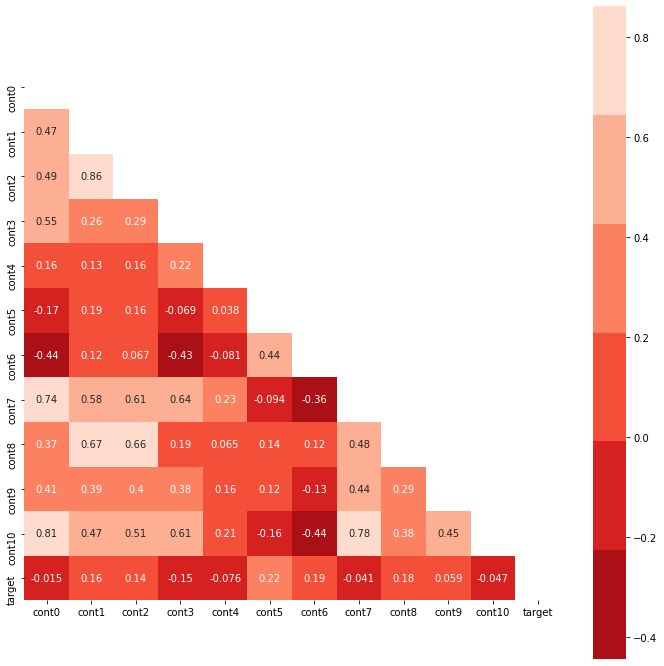

In [11]:
plt.figure(figsize=(12,12))
cmap = sns.color_palette("Reds_r")
sns.heatmap(df_train_1_corr, square=True, annot=True, mask=mask, cmap=cmap)

## LightGBMでとりあえず学習

## ラベルエンコーディング＆外れ値除去＆特徴量生成&特徴量選択  

In [6]:
# columnsの列名を確認
df_train.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

### ラベルエンコーディング(カテゴリ変数)

In [7]:
cat_list = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18']

In [8]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

In [9]:
df_train[cat_list] =oe.fit_transform(df_train[cat_list])

In [10]:
df_test[cat_list] =oe.fit_transform(df_test[cat_list])

### 外れ値除去

#### IQR(四分位範囲)外のデータを除外  
外れ値の影響を少なくするためIQRスコアを算出する  
ラベルエンコーディングしたカテゴリ変数の箱ひげ図を表示  
ラベルエンコーディング→外れ値除去→欠損値補完の順番  
※今回のデータは欠損値がないが、欠損値があるデータで外れ値除去前に欠損値を補完すると外れ値が考慮された補完となるため

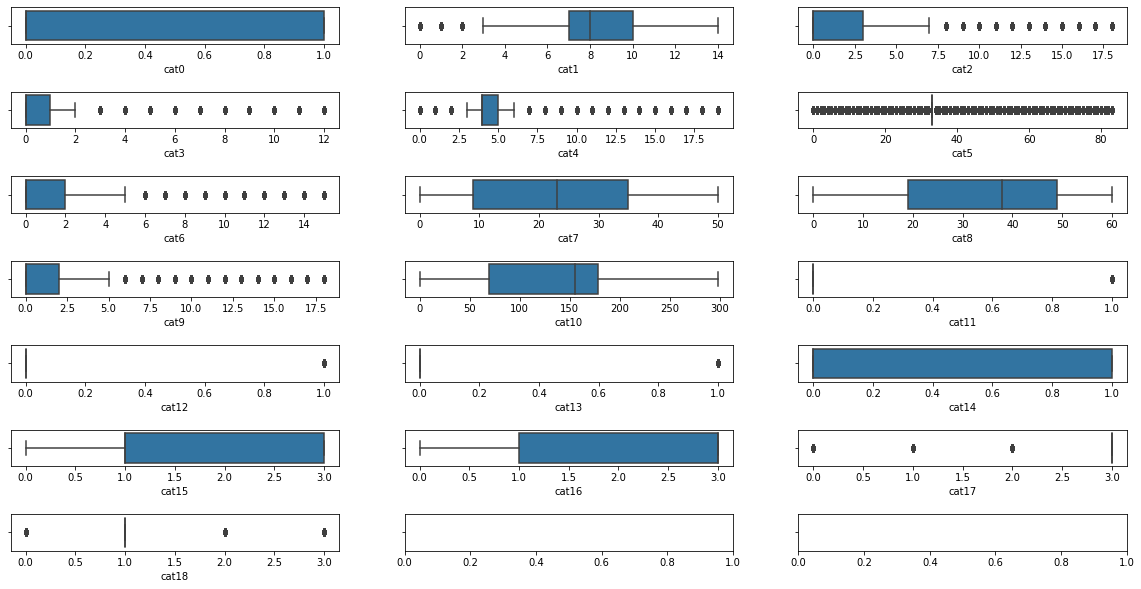

In [80]:
fig, (
      (ax0, ax1, ax2),
      (ax3, ax4, ax5),
      (ax6, ax7, ax8),
      (ax9, ax10, ax11),
      (ax12, ax13, ax14),
      (ax15, ax16, ax17),
      (ax18, ax19, ax20)
    ) = plt.subplots(nrows=7, ncols=3, sharey=True, figsize=(20, 10))

plt.subplots_adjust(hspace=1.3) 

sns.boxplot(x=df_train.cat0, ax=ax0)
sns.boxplot(x=df_train.cat1, ax=ax1)
sns.boxplot(x=df_train.cat2, ax=ax2)
sns.boxplot(x=df_train.cat3, ax=ax3)
sns.boxplot(x=df_train.cat4, ax=ax4)
sns.boxplot(x=df_train.cat5, ax=ax5)
sns.boxplot(x=df_train.cat6, ax=ax6)
sns.boxplot(x=df_train.cat7, ax=ax7)
sns.boxplot(x=df_train.cat8, ax=ax8)
sns.boxplot(x=df_train.cat9, ax=ax9)
sns.boxplot(x=df_train.cat10, ax=ax10)
sns.boxplot(x=df_train.cat11, ax=ax11)
sns.boxplot(x=df_train.cat12, ax=ax12)
sns.boxplot(x=df_train.cat13, ax=ax13)
sns.boxplot(x=df_train.cat14, ax=ax14)
sns.boxplot(x=df_train.cat15, ax=ax15)
sns.boxplot(x=df_train.cat16, ax=ax16)
sns.boxplot(x=df_train.cat17, ax=ax17)
sns.boxplot(x=df_train.cat18,ax=ax18)

plt.show()

閉区間から外れている値を除外する  
Q<sub>1/4</sub> = df_train.quantile(0.25) 第一四分位点  
Q<sub>3/4</sub> = df_train.quantile(0.75) 第三四分位点    
閉区間(Q<sub>1/4</sub>- 1.5\*IQR,Q<sub>3/4</sub>- 1.5\*IQR  IQR=Q<sub>3/4</sub>-Q<sub>1/4</sub>)

In [11]:
# IQRスコア外のデータを削除(列毎処理)
# id列からcont10までの外れ値をNaNに変換
for i in df_train.columns:
    if i != 'target':
        q1 = df_train[i].quantile(0.25)
        q3 = df_train[i].quantile(0.75)
        iqr = q3 - q1
        df_train[i] = df_train[i][~((df_train[i]<(q1-1.5*iqr)) | (df_train[i]>(q3+1.5*iqr)))]

In [12]:
for i in df_test.columns:
    if i != 'target':
        q1 = df_test[i].quantile(0.25)
        q3 = df_test[i].quantile(0.75)
        iqr = q3 - q1
        df_test[i] = df_test[i][~((df_test[i]<(q1-1.5*iqr)) | (df_test[i]>(q3+1.5*iqr)))]

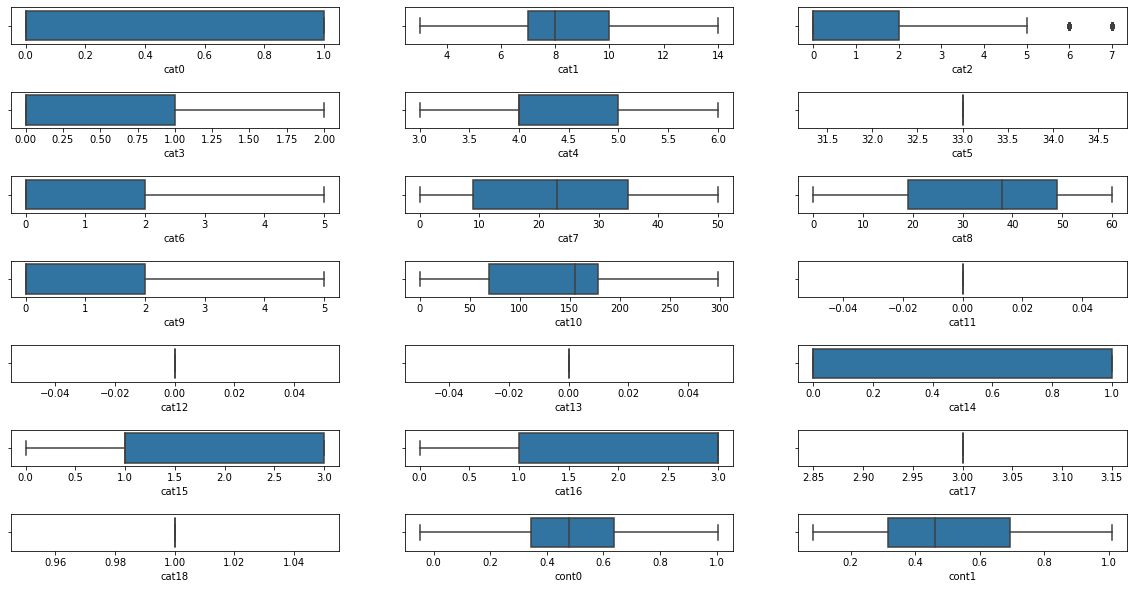

In [83]:
# 外れ値除去できたか箱ひげ図で確認
fig, (
      (ax0, ax1, ax2),
      (ax3, ax4, ax5),
      (ax6, ax7, ax8),
      (ax9, ax10, ax11),
      (ax12, ax13, ax14),
      (ax15, ax16, ax17),
      (ax18, ax19, ax20)
    ) = plt.subplots(nrows=7, ncols=3, sharey=True, figsize=(20, 10))

plt.subplots_adjust(hspace=1.3) 

sns.boxplot(x=df_train.cat0, ax=ax0)
sns.boxplot(x=df_train.cat1, ax=ax1)
sns.boxplot(x=df_train.cat2, ax=ax2)
sns.boxplot(x=df_train.cat3, ax=ax3)
sns.boxplot(x=df_train.cat4, ax=ax4)
sns.boxplot(x=df_train.cat5, ax=ax5)
sns.boxplot(x=df_train.cat6, ax=ax6)
sns.boxplot(x=df_train.cat7, ax=ax7)
sns.boxplot(x=df_train.cat8, ax=ax8)
sns.boxplot(x=df_train.cat9, ax=ax9)
sns.boxplot(x=df_train.cat10, ax=ax10)
sns.boxplot(x=df_train.cat11, ax=ax11)
sns.boxplot(x=df_train.cat12, ax=ax12)
sns.boxplot(x=df_train.cat13, ax=ax13)
sns.boxplot(x=df_train.cat14, ax=ax14)
sns.boxplot(x=df_train.cat15, ax=ax15)
sns.boxplot(x=df_train.cat16, ax=ax16)
sns.boxplot(x=df_train.cat17, ax=ax17)
sns.boxplot(x=df_train.cat18,ax=ax18)
sns.boxplot(x=df_train.cont0,ax=ax19)
sns.boxplot(x=df_train.cont1,ax=ax20)

plt.show()

In [84]:
# NaNに置換されたデータ数の確認
df_train.isnull().sum()

id            0
cat0          0
cat1      19097
cat2      41062
cat3      16841
cat4      35264
cat5      61437
cat6      23398
cat7          0
cat8          0
cat9      26809
cat10         0
cat11     41068
cat12     42861
cat13      7288
cat14         0
cat15         0
cat16         0
cat17     52875
cat18     44518
cont0         0
cont1         0
cont2         0
cont3         0
cont4         0
cont5         0
cont6         0
cont7         0
cont8      1915
cont9         9
cont10    35952
target        0
dtype: int64

In [85]:
df_test.isnull().sum()

id            0
cat0          0
cat1          0
cat2      27540
cat3      11418
cat4      23533
cat5      41084
cat6      15622
cat7          0
cat8          0
cat9      12596
cat10         0
cat11     27414
cat12     28902
cat13      4984
cat14         0
cat15         0
cat16         0
cat17     34934
cat18     29932
cont0         0
cont1         0
cont2         0
cont3         0
cont4         0
cont5         0
cont6         0
cont7         0
cont8      1292
cont9         2
cont10    24108
dtype: int64

In [13]:
# NaNを平均値で補完
for i in df_train.columns:
    if df_train[i].isnull().sum() > 0:
        df_train[i].fillna(df_train[i].mean(), inplace=True)

In [14]:
# NaNを平均値で補完
for i in df_test.columns:
    if df_test[i].isnull().sum() > 0:
        df_test[i].fillna(df_test[i].mean(), inplace=True)

In [16]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,0.0,8.0,0.0,1.0,4.416517,33.0,0.000000,44.0,54.0,0.000000,258.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,0.0,8.0,0.0,0.0,4.000000,33.0,0.764825,48.0,3.0,5.000000,162.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,0.0,10.0,0.0,0.0,4.000000,33.0,0.000000,30.0,38.0,0.920989,69.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,0.0,10.0,0.0,2.0,4.000000,33.0,0.000000,50.0,3.0,5.000000,241.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.448646,0
4,4,0.0,8.0,6.0,1.0,4.000000,33.0,2.000000,32.0,54.0,0.000000,75.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [17]:
df_test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,0.0,5.0,0.0,0.0,5.0,33.0,0.000000,8.0,23.0,0.0,249.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.449084
1,6,0.0,7.0,2.0,0.0,4.0,33.0,0.765786,31.0,51.0,0.0,269.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,0.0,13.0,2.0,0.0,5.0,33.0,0.000000,8.0,28.0,0.0,121.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,9,1.0,11.0,2.0,0.0,5.0,33.0,0.000000,30.0,23.0,0.0,162.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,11,0.0,5.0,0.0,1.0,5.0,33.0,0.000000,8.0,46.0,0.0,173.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


#### 特徴量生成

In [15]:
#Featuretoolを使うため連続値だけのdfを作成
df_train_numerical = df_train[['id','cont0', 'cont1', 'cont2', 'cont3', 'cont4','cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']]
df_test_numerical = df_test[['id','cont0', 'cont1', 'cont2', 'cont3', 'cont4','cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']]

In [16]:
df_train_numerical

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,0,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,1,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,2,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,3,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.448646
4,4,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,0.681700,0.500730,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007
299996,499995,0.489226,0.790664,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939
299997,499996,0.487882,0.522347,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144
299998,499997,0.331900,0.812891,0.808045,0.630708,0.346898,0.735147,0.563488,0.609836,0.680430,0.318453,0.335822


In [17]:
#Entityを作成
es = ft.EntitySet(id='df_train_numerical')  # ここのidの命名はなんでも良いです
es.entity_from_dataframe(
    entity_id='df_train_numerical',  #  ここのidの命名もご自由に
    dataframe=df_train_numerical,  # 対象とするDataframeを指定
    index='id'
)

Entityset: df_train_numerical
  Entities:
    df_train_numerical [Rows: 300000, Columns: 12]
  Relationships:
    No relationships

In [18]:
#特徴量を生成　add_numeric:列同士の足し算　subtract_numeric: 列同士を引き算　multiply_numeric: 列同士を掛け算　divide_numeric: 列同士を割り算
aggregation_list = []
transform_list  = ['add_numeric','subtract_numeric', 'multiply_numeric','divide_numeric']

feature_matrix, features_dfs = ft.dfs(
    entityset=es,
    target_entity="df_train_numerical",
    agg_primitives=aggregation_list,
    trans_primitives=transform_list,
    max_depth=1
)

print(feature_matrix.shape)

(300000, 286)


In [19]:
feature_matrix = feature_matrix.reset_index()

In [20]:
#作った特徴量をdf_trainに結合
feature_matrix = feature_matrix.drop(columns=['id','cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9','cont10'])

In [21]:
df_train = pd.concat([df_train, feature_matrix],axis=1)

In [22]:
df_train 

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,cont0 + cont1,cont0 + cont10,cont0 + cont2,cont0 + cont3,cont0 + cont4,cont0 + cont5,cont0 + cont6,cont0 + cont7,cont0 + cont8,cont0 + cont9,cont1 + cont10,cont1 + cont2,cont1 + cont3,cont1 + cont4,cont1 + cont5,cont1 + cont6,cont1 + cont7,cont1 + cont8,cont1 + cont9,cont10 + cont2,cont10 + cont3,cont10 + cont4,cont10 + cont5,cont10 + cont6,cont10 + cont7,cont10 + cont8,cont10 + cont9,cont2 + cont3,...,cont6 * cont8,cont6 * cont9,cont7 * cont8,cont7 * cont9,cont8 * cont9,cont0 - cont1,cont0 - cont10,cont0 - cont2,cont0 - cont3,cont0 - cont4,cont0 - cont5,cont0 - cont6,cont0 - cont7,cont0 - cont8,cont0 - cont9,cont1 - cont10,cont1 - cont2,cont1 - cont3,cont1 - cont4,cont1 - cont5,cont1 - cont6,cont1 - cont7,cont1 - cont8,cont1 - cont9,cont10 - cont2,cont10 - cont3,cont10 - cont4,cont10 - cont5,cont10 - cont6,cont10 - cont7,cont10 - cont8,cont10 - cont9,cont2 - cont3,cont2 - cont4,cont2 - cont5,cont2 - cont6,cont2 - cont7,cont2 - cont8,cont2 - cont9,cont3 - cont4,cont3 - cont5,cont3 - cont6,cont3 - cont7,cont3 - cont8,cont3 - cont9,cont4 - cont5,cont4 - cont6,cont4 - cont7,cont4 - cont8,cont4 - cont9,cont5 - cont6,cont5 - cont7,cont5 - cont8,cont5 - cont9,cont6 - cont7,cont6 - cont8,cont6 - cont9,cont7 - cont8,cont7 - cont9,cont8 - cont9
0,0,0.0,8.0,0.000000,1.000000,4.416517,33.0,0.000000,44.0,54.0,0.000000,258.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0,1.485207,1.295773,1.389297,1.425407,1.311775,1.251530,1.222042,1.421779,1.445112,1.594864,1.521264,1.614788,1.650898,1.537266,1.477021,1.447533,1.647270,1.670603,1.820355,1.425354,1.461464,1.347832,1.287587,1.258099,1.457836,1.481169,1.630921,1.554988,...,0.482781,0.571462,0.645616,0.764209,0.786725,-0.225491,-0.036057,-0.129581,-0.165691,-0.052059,0.008186,0.037674,-0.162063,-0.185396,-0.335148,0.189434,0.095910,0.059800,0.173432,0.233677,0.263165,0.063428,0.040095,-0.109657,-0.093524,-0.129634,-0.016002,0.044243,0.073731,-0.126006,-0.149339,-0.299091,-0.036111,0.077521,0.137767,0.167254,-0.032482,-0.055815,-0.205568,0.113632,0.173877,0.203365,0.003629,-0.019704,-0.169457,0.060245,0.089733,-0.110003,-0.133336,-0.283089,0.029487,-0.170249,-0.193582,-0.343335,-0.199736,-0.223069,-0.372822,-0.023333,-0.173086,-0.149753
1,1,0.0,8.0,0.000000,0.000000,4.000000,33.0,0.764825,48.0,3.0,5.000000,162.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0,0.699657,0.864456,0.757112,0.912093,0.759710,0.728505,0.970771,0.779428,0.770080,1.298133,0.822659,0.715314,0.870296,0.717912,0.686708,0.928973,0.737630,0.728282,1.256335,0.880114,1.035095,0.882712,0.851507,1.093773,0.902430,0.893082,1.421135,0.927751,...,0.239629,0.556484,0.163216,0.379032,0.370362,0.041798,-0.123002,-0.015658,-0.170639,-0.018255,0.012949,-0.229316,-0.037974,-0.028625,-0.556679,-0.164800,-0.057455,-0.212437,-0.060053,-0.028849,-0.271114,-0.079772,-0.070423,-0.598476,0.107344,-0.047637,0.104747,0.135951,-0.106314,0.085028,0.094377,-0.433677,-0.154981,-0.002598,0.028607,-0.213659,-0.022316,-0.012968,-0.541021,0.152384,0.183588,-0.058677,0.132665,0.142014,-0.386040,0.031204,-0.211061,-0.019719,-0.010370,-0.538423,-0.242265,-0.050923,-0.041574,-0.569628,0.191343,0.200691,-0.327362,0.009348,-0.518705,-0.528053
2,2,0.0,10.0,0.000000,0.000000,4.000000,33.0,0.000000,30.0,38.0,0.920989,69.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0,0.825021,1.051724,0.845526,1.118623,1.295958,1.055149,0.854385,0.891107,0.914575,0.794967,0.872201,0.666004,0.939100,1.116436,0.875626,0.674862,0.711584,0.735052,0.615444,0.892707,1.165804,1.343139,1.102329,0.901566,0.938287,0.961756,0.842148,0.959606,...,0.145177,0

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 307 entries, id to cont8 - cont9
dtypes: float64(305), int64(2)
memory usage: 702.7 MB


### testデータについても同様に特徴量を生成

In [24]:
es2 = ft.EntitySet(id='df_test_numerical')  # ここのidの命名はなんでも良いです
es2.entity_from_dataframe(
    entity_id='df_test_numerical',  #  ここのidの命名もご自由に
    dataframe=df_test_numerical,  # 対象とするDataframeを指定
    index='id'
)

Entityset: df_test_numerical
  Entities:
    df_test_numerical [Rows: 200000, Columns: 12]
  Relationships:
    No relationships

In [25]:
aggregation_list = []
transform_list  = ['add_numeric','subtract_numeric', 'multiply_numeric','divide_numeric']

feature_matrix, features_dfs = ft.dfs(
    entityset=es2,
    target_entity="df_test_numerical",
    agg_primitives=aggregation_list,
    trans_primitives=transform_list,
    max_depth=1
)
print(feature_matrix.shape)

(200000, 286)


In [26]:
feature_matrix = feature_matrix.reset_index()

In [27]:
feature_matrix = feature_matrix.drop(columns=['id','cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9','cont10'])

In [28]:
feature_matrix

,cont0 + cont1,cont0 + cont10,cont0 + cont2,cont0 + cont3,cont0 + cont4,cont0 + cont5,cont0 + cont6,cont0 + cont7,cont0 + cont8,cont0 + cont9,cont1 + cont10,cont1 + cont2,cont1 + cont3,cont1 + cont4,cont1 + cont5,cont1 + cont6,cont1 + cont7,cont1 + cont8,cont1 + cont9,cont10 + cont2,cont10 + cont3,cont10 + cont4,cont10 + cont5,cont10 + cont6,cont10 + cont7,cont10 + cont8,cont10 + cont9,cont2 + cont3,cont2 + cont4,cont2 + cont5,cont2 + cont6,cont2 + cont7,cont2 + cont8,cont2 + cont9,cont3 + cont4,cont3 + cont5,cont3 + cont6,cont3 + cont7,cont3 + cont8,cont3 + cont9,cont4 + cont5,cont4 + cont6,cont4 + cont7,cont4 + cont8,cont4 + cont9,cont5 + cont6,cont5 + cont7,cont5 + cont8,cont5 + cont9,cont6 + cont7,cont6 + cont8,cont6 + cont9,cont7 + cont8,cont7 + cont9,cont8 + cont9,cont0 / cont1,cont0 / cont10,cont0 / cont2,cont0 / cont3,cont0 / cont4,...,cont6 * cont8,cont6 * cont9,cont7 * cont8,cont7 * cont9,cont8 * cont9,cont0 - cont1,cont0 - cont10,cont0 - cont2,cont0 - cont3,cont0 - cont4,cont0 - cont5,cont0 - cont6,cont0 - cont7,cont0 - cont8,cont0 - cont9,cont1 - cont10,cont1 - cont2,cont1 - cont3,cont1 - cont4,cont1 - cont5,cont1 - cont6,cont1 - cont7,cont1 - cont8,cont1 - cont9,cont10 - cont2,cont10 - cont3,cont10 - cont4,cont10 - cont5,cont10 - cont6,cont10 - cont7,cont10 - cont8,cont10 - cont9,cont2 - cont3,cont2 - cont4,cont2 - cont5,cont2 - cont6,cont2 - cont7,cont2 - cont8,cont2 - cont9,cont3 - cont4,cont3 - cont5,cont3 - cont6,cont3 - cont7,cont3 - cont8,cont3 - cont9,cont4 - cont5,cont4 - cont6,cont4 - cont7,cont4 - cont8,cont4 - cont9,cont5 - cont6,cont5 - cont7,cont5 - cont8,cont5 - cont9,cont6 - cont7,cont6 - cont8,cont6 - cont9,cont7 - cont8,cont7 - cont9,cont8 - cont9
0,1.443810,1.157204,1.286486,1.431274,0.936157,1.064347,1.259369,1.363813,1.306450,1.068107,1.184774,1.314056,1.458844,0.963727,1.091917,1.286939,1.391383,1.334021,1.095678,1.027451,1.172238,0.677121,0.805312,1.000334,1.104777,1.047415,0.809072,1.301520,0.806403,0.934593,1.129615,1.234059,1.176697,0.938354,0.951191,1.079381,1.274403,1.378847,1.321485,1.083142,0.584264,0.779286,0.883730,0.826368,0.588025,0.907476,1.011920,0.954558,0.716215,1.206942,1.149580,0.911237,1.254024,1.015681,0.958318,0.962524,1.576808,1.224345,0.979210,3.105284,...,0.329829,0.198443,0.392321,0.236041,0.215392,-0.027570,0.259035,0.129753,-0.015034,0.480083,0.351893,0.156871,0.052427,0.109789,0.348132,0.286606,0.157324,0.012536,0.507653,0.379463,0.184441,0.079997,0.137360,0.375703,-0.129282,-0.274070,0.221047,0.092857,-0.102165,-0.206609,-0.149246,0.089097,-0.144788,0.350329,0.222139,0.027117,-0.077327,-0.019964,0.218379,0.495117,0.366927,0.171905,0.067461,0.124823,0.363167,-0.128190,-0.323212,-0.427656,-0.370294,-0.131950,-0.195022,-0.299466,-0.242103,-0.003760,-0.104444,-0.047081,0.191262,0.057363,0.295706,0.238343
1,0.925340,1.000217,1.540522,1.128239,1.211806,1.406860,0.860624,1.266251,0.959581,1.177157,0.702283,1.242588,0.830306,0.913873,1.108927,0.562691,0.968318,0.661647,0.879223,1.317465,0.905182,0.988750,1.183804,0.637567,1.043194,0.736524,0.954100,1.445487,1.529055,1.724109,1.177873,1.583499,1.276829,1.494405,1.116772,1.311826,0.765590,1.171217,0.864546,1.082122,1.395393,0.849157,1.254784,0.948113,1.165689,1.044211,1.449838,1.143167,1.360743,0.903602,0.596931,0.814507,1.002558,1.220134,0.913464,1.949731,1.574031,0.658464,1.183961,1.019107,...,0.086634,0.140807,0.227769,0.370197,0.196769,0.297934,0.223057,-0.317248,0.095035,0.011467,-0.183587,0.362650,-0.042977,0.263693,0.046117,-0.074877,-0.615182,-0.202899,-0.286466,-0.481520,0.064716,-0.340911,-0.034240,-0.251817,-0.540305,-0.128022,-0.211589,-0.406643,0.139593,-0.266034,0.040636,-0.176940,0.412283,0.328716,0.133662,0.679898,0.274271,0.580942,0.363365,-0.083567,-0.278621,0.267615,-0.138012,0.168659,-0.048918,-0.195054,0.351182,-0.054445,0.252226,0.034650,0.546236,0.140609,0.447280,0.229704,-0.405627,-0.098956,-0.316533,0.306671,0.089094,-0.217576
2,0.904490,0.867881,0.881165,0.801017,0.698362,0.726921,1.203029,0.791879,

In [29]:
df_test = pd.concat([df_test, feature_matrix],axis=1)

In [30]:
df_test

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont0 + cont1,cont0 + cont10,cont0 + cont2,cont0 + cont3,cont0 + cont4,cont0 + cont5,cont0 + cont6,cont0 + cont7,cont0 + cont8,cont0 + cont9,cont1 + cont10,cont1 + cont2,cont1 + cont3,cont1 + cont4,cont1 + cont5,cont1 + cont6,cont1 + cont7,cont1 + cont8,cont1 + cont9,cont10 + cont2,cont10 + cont3,cont10 + cont4,cont10 + cont5,cont10 + cont6,cont10 + cont7,cont10 + cont8,cont10 + cont9,cont2 + cont3,cont2 + cont4,...,cont6 * cont8,cont6 * cont9,cont7 * cont8,cont7 * cont9,cont8 * cont9,cont0 - cont1,cont0 - cont10,cont0 - cont2,cont0 - cont3,cont0 - cont4,cont0 - cont5,cont0 - cont6,cont0 - cont7,cont0 - cont8,cont0 - cont9,cont1 - cont10,cont1 - cont2,cont1 - cont3,cont1 - cont4,cont1 - cont5,cont1 - cont6,cont1 - cont7,cont1 - cont8,cont1 - cont9,cont10 - cont2,cont10 - cont3,cont10 - cont4,cont10 - cont5,cont10 - cont6,cont10 - cont7,cont10 - cont8,cont10 - cont9,cont2 - cont3,cont2 - cont4,cont2 - cont5,cont2 - cont6,cont2 - cont7,cont2 - cont8,cont2 - cont9,cont3 - cont4,cont3 - cont5,cont3 - cont6,cont3 - cont7,cont3 - cont8,cont3 - cont9,cont4 - cont5,cont4 - cont6,cont4 - cont7,cont4 - cont8,cont4 - cont9,cont5 - cont6,cont5 - cont7,cont5 - cont8,cont5 - cont9,cont6 - cont7,cont6 - cont8,cont6 - cont9,cont7 - cont8,cont7 - cont9,cont8 - cont9
0,5,0.0,5.0,0.0,0.000000,5.000000,33.0,0.000000,8.0,23.0,0.0,249.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.449084,1.443810,1.157204,1.286486,1.431274,0.936157,1.064347,1.259369,1.363813,1.306450,1.068107,1.184774,1.314056,1.458844,0.963727,1.091917,1.286939,1.391383,1.334021,1.095678,1.027451,1.172238,0.677121,0.805312,1.000334,1.104777,1.047415,0.809072,1.301520,0.806403,...,0.329829,0.198443,0.392321,0.236041,0.215392,-0.027570,0.259035,0.129753,-0.015034,0.480083,0.351893,0.156871,0.052427,0.109789,0.348132,0.286606,0.157324,0.012536,0.507653,0.379463,0.184441,0.079997,0.137360,0.375703,-0.129282,-0.274070,0.221047,0.092857,-0.102165,-0.206609,-0.149246,0.089097,-0.144788,0.350329,0.222139,0.027117,-0.077327,-0.019964,0.218379,0.495117,0.366927,0.171905,0.067461,0.124823,0.363167,-0.128190,-0.323212,-0.427656,-0.370294,-0.131950,-0.195022,-0.299466,-0.242103,-0.003760,-0.104444,-0.047081,0.191262,0.057363,0.295706,0.238343
1,6,0.0,7.0,2.0,0.000000,4.000000,33.0,0.765786,31.0,51.0,0.0,269.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580,0.925340,1.000217,1.540522,1.128239,1.211806,1.406860,0.860624,1.266251,0.959581,1.177157,0.702283,1.242588,0.830306,0.913873,1.108927,0.562691,0.968318,0.661647,0.879223,1.317465,0.905182,0.988750,1.183804,0.637567,1.043194,0.736524,0.954100,1.445487,1.529055,...,0.086634,0.140807,0.227769,0.370197,0.196769,0.297934,0.223057,-0.317248,0.095035,0.011467,-0.183587,0.362650,-0.042977,0.263693,0.046117,-0.074877,-0.615182,-0.202899,-0.286466,-0.481520,0.064716,-0.340911,-0.034240,-0.251817,-0.540305,-0.128022,-0.211589,-0.406643,0.139593,-0.266034,0.040636,-0.176940,0.412283,0.328716,0.133662,0.679898,0.274271,0.580942,0.363365,-0.083567,-0.278621,0.267615,-0.138012,0.168659,-0.048918,-0.195054,0.351182,-0.054445,0.252226,0.034650,0.546236,0.140609,0.447280,0.229704,-0.405627,-0.098956,-0.316533,0.306671,0.089094,-0.217576
2,8,0.0,13.0,2.0,0.000000,5.000000,33.0,0.000000,8.0,28.0,0.0,121.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592,0.904490,0.867881,0.881165,0.801017,0.698362,0.726921,1.203029,0.791879,0.797527,0.708578,0.859794,0.873077,0.792930,0.690274,0.718833,1.194941,0.783791,0.789439,0.700490,0.836469,0.756321,0.653665,0.682224,1.158332,0.747182,0.752830,0.663881,0.769605,0.666949,...,0.254816,0.188394,0.114516,0.084666,

### データを交差検証用に分割

In [31]:
# trainデータを7:3に分割
X_train, X_test = train_test_split(df_train, train_size=0.7,random_state=1)

In [32]:
X_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,cont0 + cont1,cont0 + cont10,cont0 + cont2,cont0 + cont3,cont0 + cont4,cont0 + cont5,cont0 + cont6,cont0 + cont7,cont0 + cont8,cont0 + cont9,cont1 + cont10,cont1 + cont2,cont1 + cont3,cont1 + cont4,cont1 + cont5,cont1 + cont6,cont1 + cont7,cont1 + cont8,cont1 + cont9,cont10 + cont2,cont10 + cont3,cont10 + cont4,cont10 + cont5,cont10 + cont6,cont10 + cont7,cont10 + cont8,cont10 + cont9,cont2 + cont3,...,cont6 * cont8,cont6 * cont9,cont7 * cont8,cont7 * cont9,cont8 * cont9,cont0 - cont1,cont0 - cont10,cont0 - cont2,cont0 - cont3,cont0 - cont4,cont0 - cont5,cont0 - cont6,cont0 - cont7,cont0 - cont8,cont0 - cont9,cont1 - cont10,cont1 - cont2,cont1 - cont3,cont1 - cont4,cont1 - cont5,cont1 - cont6,cont1 - cont7,cont1 - cont8,cont1 - cont9,cont10 - cont2,cont10 - cont3,cont10 - cont4,cont10 - cont5,cont10 - cont6,cont10 - cont7,cont10 - cont8,cont10 - cont9,cont2 - cont3,cont2 - cont4,cont2 - cont5,cont2 - cont6,cont2 - cont7,cont2 - cont8,cont2 - cont9,cont3 - cont4,cont3 - cont5,cont3 - cont6,cont3 - cont7,cont3 - cont8,cont3 - cont9,cont4 - cont5,cont4 - cont6,cont4 - cont7,cont4 - cont8,cont4 - cont9,cont5 - cont6,cont5 - cont7,cont5 - cont8,cont5 - cont9,cont6 - cont7,cont6 - cont8,cont6 - cont9,cont7 - cont8,cont7 - cont9,cont8 - cont9
51295,85460,0.0,10.0,0.000000,1.0,3.0,33.0,0.764825,31.0,60.0,5.000000,266.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.871147,0.541951,0.626311,0.622117,0.243285,0.092515,0.071281,0.848721,0.550586,0.377544,0.780668,0,1.413098,1.651816,1.497459,1.493264,1.114432,0.963663,0.942428,1.719868,1.421733,1.248692,1.322619,1.168262,1.164067,0.785236,0.634466,0.613232,1.390671,1.092537,0.919495,1.406979,1.402785,1.023953,0.873183,0.851949,1.629389,1.331254,1.158212,1.248428,...,0.039246,0.026912,0.467294,0.320430,0.207871,0.329197,0.090479,0.244836,0.249031,0.627862,0.778632,0.799866,0.022427,0.320561,0.493603,-0.238718,-0.084361,-0.080166,0.298665,0.449435,0.470669,-0.306770,-0.008635,0.164406,0.154357,0.158551,0.537383,0.688153,0.709387,-0.068053,0.230082,0.403124,0.004195,0.383026,0.533796,0.555030,-0.222409,0.075725,0.248767,0.378832,0.529602,0.550836,-0.226604,0.071531,0.244572,0.150770,0.172004,-0.605436,-0.307301,-0.134259,0.021234,-0.756206,-0.458071,-0.285029,-0.777440,-0.479305,-0.306263,0.298135,0.471176,0.173042
255119,425285,0.0,11.0,1.184979,1.0,4.0,33.0,0.000000,47.0,60.0,0.000000,242.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.949851,0.595453,0.920324,0.867490,0.227583,0.619677,0.271239,0.845413,0.710628,0.550379,0.448646,1,1.545305,1.398497,1.870175,1.817341,1.177434,1.569528,1.221090,1.795265,1.660480,1.500231,1.044099,1.515777,1.462943,0.823036,1.215130,0.866692,1.440867,1.306081,1.145832,1.368969,1.316136,0.676228,1.068322,0.719884,1.294059,1.159274,0.999025,1.787814,...,0.192750,0.149284,0.600775,0.465298,0.391115,0.354398,0.501206,0.029528,0.082361,0.722269,0.330175,0.678613,0.104438,0.239223,0.399472,0.146807,-0.324871,-0.272037,0.367870,-0.024224,0.324214,-0.249960,-0.115175,0.045074,-0.471678,-0.418844,0.221063,-0.171031,0.177407,-0.396768,-0.261983,-0.101733,0.052834,0.692741,0.300647,0.649085,0.074910,0.209695,0.369945,0.639907,0.247813,0.596251,0.022076,0.156862,0.317111,-0.392094,-0.043656,-0.617831,-0.483046,-0.322796,0.348438,-0.225737,-0.090952,0.069298,-0.574175,-0.439390,-0.279140,0.134785,0.295034,0.160249
245089,408526,1.0,8.0,3.000000,0.0,5.0,33.0,0.000000,19.0,38.0,2.000000,3.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.340058,0.268377,0.310116,0.224428,0.714035,0.555303,0.414089,0.469949,0.374271,0.293190,0.306396,0,0.608435,0.646454,0.650174,0.564486,1.054093,0.895361,0.754147,0.810007,0.714329,0.633248,0.574773,0.578493,0.492805,0.982412,0.823680,0.682466,0.738325,0.642647,0.561567,0.616512,0.530824,1.020431,0.861699,0.720486,0.776345,0.680667,0.599586,0.534544,...,0.154981,0.121407,0.175888,0.137784,0.109732,

In [33]:
X_test.shape

(90000, 307)

In [34]:
y_train = X_train['target']

In [35]:
y_test = X_test['target']

In [36]:
# idとtarget列を削除
X_train = X_train.drop(['id','target'], axis=1)

In [37]:
X_test = X_test.drop(['id','target'], axis=1)

In [38]:
# データ数を確認
print("X_train{},X_test{},Y_train{},Y_test{}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train(210000, 305),X_test(90000, 305),Y_train(210000,),Y_test(90000,)


#### -----ここまでデータ分割----

In [39]:
train_data = lgb.Dataset(X_train, y_train)
eval_data = lgb.Dataset(X_test, y_test)

In [40]:
X_train.columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont5 - cont6', 'cont5 - cont7', 'cont5 - cont8', 'cont5 - cont9',
       'cont6 - cont7', 'cont6 - cont8', 'cont6 - cont9', 'cont7 - cont8',
       'cont7 - cont9', 'cont8 - cont9'],
      dtype='object', length=305)

In [41]:
# LightGBM.trainのパラメータを設定
params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'binary',
'verbose': 2,
}

In [42]:
gbm = lgb.train(
params,
train_data,
valid_sets=eval_data,
num_boost_round=100,
verbose_eval=5
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55683, number of negative: 154317
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.666661
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.012858
[LightGBM] [Debug] init for col-wise cost 0.004315 seconds, init for row-wise cost 0.069134 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73264
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 299
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265157 -> initscore=-1.019334
[LightGBM] [Info] Start training from score -1.019334
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [D

In [43]:
# Feature＿importanceを表示
importance = pd.DataFrame(gbm.feature_importance(), index=X_train.columns, columns=['importance']).sort_values('importance',ascending= False)
display(importance)

,importance
cat1,182
cont4,118
cat2,109
cat14,99
cat10,87
...,...
cont10 / cont9,0
cat11,0
cat5,0
cont10 / cont1,0


In [48]:
df_test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,diff_1,diff_2,diff_3,diff_4,diff_5,diff_7,diff_8,diff_9,diff_10,diff_11,diff_12,diff_13,diff_14,rat_1,rat_2,rat_3,rat_4,rat_5,rat_6,pow_0,pow_1,pow_2,pow_3,pow_4,pow_5,pow_6,pow_7,pow_8,pow_9,pow_10,sqrt_0,sqrt_1,sqrt_2,sqrt_3,sqrt_4,sqrt_5,sqrt_6,sqrt_7,sqrt_8,sqrt_9,sqrt_10,poly_0,poly_1,poly_2,poly_3,poly_4,poly_5,poly_6,poly_7,poly_8,poly_9,poly_10,poly_b_0,poly_b_1,poly_b_2,poly_b_3,poly_b_4,poly_b_5,poly_b_6,poly_b_7,poly_b_8,poly_b_9,poly_b_10,drat_1,drat_2,drat_3,drat_4,drat_5,drat_6
0,5,0.0,5.0,0.0,0.0,5.0,33.0,0.000000,8.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.449084,5.0,0.0,28.0,8.000000,23.0,0.0,1.0,0.027570,0.144788,0.128190,0.104444,0.238343,0.259035,0.800410,0.908003,2.817419,1.019178,1.373774,1.137633,0.501434,0.541240,0.334508,0.522952,0.052001,0.126898,0.303876,0.429933,0.357999,0.129591,0.201677,0.841498,0.857724,0.760504,0.850385,0.477532,0.596848,0.742462,0.809749,0.773518,0.599990,0.670138,8.552067,9.008370,6.567891,8.799384,2.556192,3.796318,6.187251,7.717933,6.855648,3.836665,4.858836,1.412191,1.359268,1.729008,1.382831,4.385253,2.807197,1.814062,1.525104,1.671317,2.777874,2.226753,0.127056,0.141334,0.463958,0.161402,0.248239,0.175905
1,6,0.0,7.0,2.0,0.0,4.0,33.0,0.765786,31.0,51.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580,7.0,2.0,29.0,30.234214,51.0,0.0,1.0,0.297934,0.412283,0.195054,0.405627,0.217576,0.223057,1.408358,0.836286,0.811326,1.475999,1.497552,1.223841,0.374100,0.098410,0.862828,0.266878,0.360203,0.632380,0.061995,0.428520,0.121065,0.319813,0.150994,0.782072,0.560092,0.963787,0.718751,0.774706,0.891753,0.498986,0.809082,0.589867,0.752011,0.623362,7.050983,3.355795,12.547046,5.718035,6.882475,10.035161,2.740895,7.701230,3.708236,6.386103,4.150856,1.634957,3.187725,1.076559,1.935725,1.666196,1.257508,4.016268,1.527617,2.874029,1.768284,2.573472,0.260047,0.147505,0.124071,0.213991,0.232654,0.186183
2,8,0.0,13.0,2.0,0.0,5.0,33.0,0.000000,8.0,28.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592,13.0,2.0,28.0,8.000000,28.0,0.0,1.0,0.008088,0.080148,0.028559,0.411150,0.088949,0.044696,1.521669,1.839202,3.171434,1.163656,2.469821,1.907622,0.208199,0.200884,0.180520,0.118838,0.058599,0.073242,0.557620,0.112621,0.116443,0.063650,0.169408,0.675492,0.669478,0.651825,0.587136,0.492009,0.520223,0.864141,0.579301,0.584156,0.502284,0.641555,4.947040,4.848081,4.568540,3.674346,2.679160,2.939095,9.194663,3.578914,3.637736,2.770642,4.413228,2.191594,2.231141,2.353627,2.900832,4.130985,3.695053,1.339154,2.979827,2.930506,3.963709,2.429589,0.257167,0.325194,0.556700,0.215765,0.451388,0.337960
3,9,1.0,11.0,2.0,0.0,5.0,33.0,0.000000,30.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723,10.0,2.0,28.0,30.000000,23.0,0.0,0.0,0.327400,0.036972,0.070364,0.157158,0.133146,0.012969,1.278167,1.093190,0.741829,1.461311,1.658041,2.121720,0.114712,0.443679,0.358732,0.315811,0.650196,0.541671,0.290224,0.145593,0.231996,0.121462,0.106095,0.581972,0.816145,0.773914,0.749647,0.897969,0.857895,0.733979,0.617710,0.694017,0.590351,0.570721,3.611154,7.879890,6.864571,6.336344,10.233308,9.013288,6.015415,4.072574,5.264265,3.714266,3.477378,2.952538,1.501294,1.669609,1.779452,1.240160,1.358727,1.856237,2.620777,2.076155,2.869325,3.070094,0.190735,0.181120,0.119544,0.259177,0.295859,0.357992
4,11,0.0,5.0,0.0,1.0,5.0,33.0,0.000000,8.0,46.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781,5.0,1.0,28.0,8.000000,46.0,0.0,1.0,0.140

In [44]:
df_pred = df_test.drop(['id'], axis=1)

In [45]:
y_pred = gbm.predict(df_pred, num_iteration=gbm.best_iteration)

In [61]:
print(type(y_pred))
print(type(df_test['id']))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [46]:
y_pred_df = pd.DataFrame({'id':df_test['id'], 'target':y_pred})

In [47]:
y_pred_df

,id,target
0,5,0.147097
1,6,0.713709
2,8,0.059127
3,9,0.127019
4,11,0.183979
...,...,...
199995,499983,0.852559
199996,499984,0.038751
199997,499987,0.826132
199998,499994,0.138585


In [48]:
y_pred_df.to_csv('submission.csv',index=False)